<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU/GRU_EURCHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 119 (delta 53), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (119/119), 107.55 KiB | 5.66 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 13 12:44:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURCHF'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [ ]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 4.1MB/s 
     |████████████████████████████████| 174kB 18.4MB/s 
     |████████████████████████████████| 102kB 10.7MB/s 
     |████████████████████████████████| 143kB 18.3MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 


In [ ]:
!pip install wandb -qq

In [ ]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [ ]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture - This is a simplified version of the VGG19 architecture
    model = Sequential()
    
    # input layer
    model.add(GRU(units=config.input_size,
                  activation=config.activation,
                  return_sequences=True,
                  input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # hidden layer
    model.add(GRU(units=config.hidden_size))
    model.add(Dropout(config.dropout))
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_GRU')

Create sweep with ID: z8xr4nj6
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU/sweeps/z8xr4nj6


In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id, train, project='ACSE_9_GRU')

wandb: Agent Starting Run: d1l2difd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 26s 144ms/step - loss: 0.2698 - mean_squared_error: 0.2698 - mean_absolute_error: 0.4644 - val_loss: 0.0466 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1664
Epoch 2/100
16/16 [==============================] - 1s 68ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1531 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1340
Epoch 3/100
16/16 [==============================] - 1s 69ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.1059 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0642
Epoch 4/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0785 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0571
Epoch 5/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0106 - mean_square

epoch,52
loss,0.00421
mean_squared_error,0.00421
mean_absolute_error,0.0444
val_loss,0.00364
val_mean_squared_error,0.00364
val_mean_absolute_error,0.04513
_runtime,88
_timestamp,1626166213
_step,52
best_val_loss,0.00355


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: c6tryqsh with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 5s 123ms/step - loss: 0.2990 - mean_squared_error: 0.2990 - mean_absolute_error: 0.4815 - val_loss: 0.0477 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1774
Epoch 2/50
16/16 [==============================] - 1s 70ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1666 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - val_mean_absolute_error: 0.2218
Epoch 3/50
16/16 [==============================] - 1s 67ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1716 - val_loss: 0.0472 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1880
Epoch 4/50
16/16 [==============================] - 1s 67ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - mean_absolute_error: 0.1438 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1647
Epoch 5/50
16/16 [==============================] - 1s 63ms/step - loss: 0.0279 - mean_squared_erro

epoch,49
loss,0.00493
mean_squared_error,0.00493
mean_absolute_error,0.04822
val_loss,0.00477
val_mean_squared_error,0.00477
val_mean_absolute_error,0.05179
_runtime,61
_timestamp,1626166284
_step,49
best_val_loss,0.00477


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dwpberdv with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 5s 120ms/step - loss: 0.1417 - mean_squared_error: 0.1417 - mean_absolute_error: 0.2990 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0734
Epoch 2/200
16/16 [==============================] - 1s 66ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0879 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0684
Epoch 3/200
16/16 [==============================] - 1s 65ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0756 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0612
Epoch 4/200
16/16 [==============================] - 1s 64ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0627 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0545
Epoch 5/200
16/16 [==============================] - 1s 64ms/step - loss: 0.0086 - mean_squared

epoch,148
loss,0.00268
mean_squared_error,0.00268
mean_absolute_error,0.03091
val_loss,0.0025
val_mean_squared_error,0.0025
val_mean_absolute_error,0.03884
_runtime,173
_timestamp,1626166468
_step,148
best_val_loss,0.00244


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7jsd4wkt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 6s 90ms/step - loss: 0.2016 - mean_squared_error: 0.2016 - mean_absolute_error: 0.3737 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1790
Epoch 2/200
32/32 [==============================] - 2s 64ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_error: 0.1275 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1035
Epoch 3/200
32/32 [==============================] - 2s 64ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0785 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0516
Epoch 4/200
32/32 [==============================] - 2s 66ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0627 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0545
Epoch 5/200
32/32 [==============================] - 2s 65ms/step - loss: 0.0083 - mean_squared_

epoch,39
loss,0.00413
mean_squared_error,0.00413
mean_absolute_error,0.04382
val_loss,0.00354
val_mean_squared_error,0.00354
val_mean_absolute_error,0.04488
_runtime,93
_timestamp,1626166572
_step,39
best_val_loss,0.00311


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oc163ktw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 5s 192ms/step - loss: 0.3359 - mean_squared_error: 0.3359 - mean_absolute_error: 0.5289 - val_loss: 0.1527 - val_mean_squared_error: 0.1527 - val_mean_absolute_error: 0.3141
Epoch 2/50
8/8 [==============================] - 1s 76ms/step - loss: 0.1989 - mean_squared_error: 0.1989 - mean_absolute_error: 0.3930 - val_loss: 0.0741 - val_mean_squared_error: 0.0741 - val_mean_absolute_error: 0.2093
Epoch 3/50
8/8 [==============================] - 1s 68ms/step - loss: 0.0905 - mean_squared_error: 0.0905 - mean_absolute_error: 0.2451 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1363
Epoch 4/50
8/8 [==============================] - 1s 71ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1272 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1485
Epoch 5/50
8/8 [==============================] - 1s 70ms/step - loss: 0.0223 - mean_squared_error: 0.0223 

epoch,49
loss,0.00506
mean_squared_error,0.00506
mean_absolute_error,0.04655
val_loss,0.0049
val_mean_squared_error,0.0049
val_mean_absolute_error,0.05226
_runtime,38
_timestamp,1626166622
_step,49
best_val_loss,0.0049


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jnavt8vq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 59ms/step - loss: 0.1142 - mean_squared_error: 0.1142 - mean_absolute_error: 0.2675 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0977
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0990 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0589
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0646 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0557
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0651 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0497
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0080 - mean_squared_erro

epoch,99
loss,0.00242
mean_squared_error,0.00242
mean_absolute_error,0.0314
val_loss,0.00242
val_mean_squared_error,0.00242
val_mean_absolute_error,0.03727
_runtime,23
_timestamp,1626166667
_step,99
best_val_loss,0.00238


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: psek3so2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 5s 63ms/step - loss: 0.1716 - mean_squared_error: 0.1716 - mean_absolute_error: 0.3323 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1036
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0873 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0770
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0713 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0628
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0621 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0605
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0075 - mean_squared_error

epoch,49
loss,0.00374
mean_squared_error,0.00374
mean_absolute_error,0.04001
val_loss,0.00367
val_mean_squared_error,0.00367
val_mean_absolute_error,0.04518
_runtime,19
_timestamp,1626166698
_step,49
best_val_loss,0.00367


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6lug5eli with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 4s 117ms/step - loss: 0.1629 - mean_squared_error: 0.1629 - mean_absolute_error: 0.3294 - val_loss: 0.0541 - val_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.2207
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1626 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0871
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.1053 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0676
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0696 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0823
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0083 -

epoch,49
loss,0.00311
mean_squared_error,0.00311
mean_absolute_error,0.03763
val_loss,0.00322
val_mean_squared_error,0.00322
val_mean_absolute_error,0.04269
_runtime,15
_timestamp,1626166725
_step,49
best_val_loss,0.00311


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: u0aews6l with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 6s 100ms/step - loss: 0.0970 - mean_squared_error: 0.0970 - mean_absolute_error: 0.2349 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0707
Epoch 2/50
32/32 [==============================] - 2s 69ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1028 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0581
Epoch 3/50
32/32 [==============================] - 2s 73ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0856 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0530
Epoch 4/50
32/32 [==============================] - 2s 73ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0862 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0514
Epoch 5/50
32/32 [==============================] - 2s 71ms/step - loss: 0.0116 - mean_squared_erro

epoch,49
loss,0.00509
mean_squared_error,0.00509
mean_absolute_error,0.04635
val_loss,0.00327
val_mean_squared_error,0.00327
val_mean_absolute_error,0.04265
_runtime,121
_timestamp,1626166857
_step,49
best_val_loss,0.0032


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▂▂▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▂▂▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▄▃▂▃▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▁▂▁▁▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tgmkeioa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 5s 130ms/step - loss: 0.3478 - mean_squared_error: 0.3478 - mean_absolute_error: 0.5344 - val_loss: 0.1174 - val_mean_squared_error: 0.1174 - val_mean_absolute_error: 0.2612
Epoch 2/100
16/16 [==============================] - 1s 75ms/step - loss: 0.1339 - mean_squared_error: 0.1339 - mean_absolute_error: 0.2845 - val_loss: 0.0618 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.2035
Epoch 3/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - mean_absolute_error: 0.1859 - val_loss: 0.0685 - val_mean_squared_error: 0.0685 - val_mean_absolute_error: 0.2244
Epoch 4/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1875 - val_loss: 0.0713 - val_mean_squared_error: 0.0713 - val_mean_absolute_error: 0.2306
Epoch 5/100
16/16 [==============================] - 1s 73ms/step - loss: 0.0493 - mean_squared

epoch,99
loss,0.00651
mean_squared_error,0.00651
mean_absolute_error,0.055
val_loss,0.00795
val_mean_squared_error,0.00795
val_mean_absolute_error,0.07105
_runtime,127
_timestamp,1626167029
_step,99
best_val_loss,0.00795


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yaxvbroc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 5s 187ms/step - loss: 0.1495 - mean_squared_error: 0.1495 - mean_absolute_error: 0.2855 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1444
Epoch 2/200
8/8 [==============================] - 1s 76ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1439 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0591
Epoch 3/200
8/8 [==============================] - 1s 71ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0702 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0515
Epoch 4/200
8/8 [==============================] - 1s 72ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0655 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0791
Epoch 5/200
8/8 [==============================] - 1s 76ms/step - loss: 0.0101 - mean_squared_error: 0.

epoch,24
loss,0.00587
mean_squared_error,0.00587
mean_absolute_error,0.05429
val_loss,0.00463
val_mean_squared_error,0.00463
val_mean_absolute_error,0.05616
_runtime,26
_timestamp,1626167095
_step,24
best_val_loss,0.00366


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▂▂▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▃▃▂▁▁▃▂▂▃▂▁▁▃▂▂▁▂▁▂▂▁▁
val_loss,█▂▁▃▃▁▁▁▂▂▄▂▁▂▁▂▂▁▂▁▁▂▁▁▁
val_mean_squared_error,█▂▁▃▃▁▁▁▂▂▄▂▁▂▁▂▂▁▂▁▁▂▁▁▁
val_mean_absolute_error,█▂▁▃▃▁▁▁▂▃▅▂▂▃▁▃▃▂▂▂▁▃▁▂▂
_runtime,▁▁▁▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▇▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: k3bhjhxi with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 7s 101ms/step - loss: 0.1950 - mean_squared_error: 0.1950 - mean_absolute_error: 0.3200 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0787
Epoch 2/50
32/32 [==============================] - 2s 66ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0713 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0575
Epoch 3/50
32/32 [==============================] - 2s 71ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0591 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0562
Epoch 4/50
32/32 [==============================] - 2s 67ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0548 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0553
Epoch 5/50
32/32 [==============================] - 2s 70ms/step - loss: 0.0081 - mean_squared_erro

epoch,49
loss,0.00281
mean_squared_error,0.00281
mean_absolute_error,0.03246
val_loss,0.00307
val_mean_squared_error,0.00307
val_mean_absolute_error,0.04428
_runtime,126
_timestamp,1626167241
_step,49
best_val_loss,0.00284


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▃▄▃▆▃▂▂▃▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▃▃▃▄▃▆▃▂▂▃▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▄▄▄▄▃▃▃▃▃▅▃▇▄▂▂▃▂▂▂▂▂▂▂▁▁▂▃▁▁▁▂▁▁▁▂▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7m79ubl9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 7s 97ms/step - loss: 0.1313 - mean_squared_error: 0.1313 - mean_absolute_error: 0.2667 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0724
Epoch 2/100
32/32 [==============================] - 2s 68ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0806 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0590
Epoch 3/100
32/32 [==============================] - 2s 73ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0673 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0555
Epoch 4/100
32/32 [==============================] - 2s 70ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0598 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0531
Epoch 5/100
32/32 [==============================] - 2s 72ms/step - loss: 0.0066 - mean_squared_

epoch,64
loss,0.00289
mean_squared_error,0.00289
mean_absolute_error,0.03426
val_loss,0.00306
val_mean_squared_error,0.00306
val_mean_absolute_error,0.0444
_runtime,164
_timestamp,1626167446
_step,64
best_val_loss,0.00261


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▅▄▄▄▃▃▇▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▅▄▅▄▄▄▃▃▇▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▅▄▄▃▃▄▃▃█▂▂▂▃▂▂▂▂▂▂▁▂▁▂▂▁▁▁▃▂▃▂▁▁▁▁▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v5s0y6gw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 5s 200ms/step - loss: 0.2073 - mean_squared_error: 0.2073 - mean_absolute_error: 0.3905 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1873
Epoch 2/200
8/8 [==============================] - 1s 78ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1711 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1005
Epoch 3/200
8/8 [==============================] - 1s 81ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1024 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0910
Epoch 4/200
8/8 [==============================] - 1s 83ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0859 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0848
Epoch 5/200
8/8 [==============================] - 1s 81ms/step - loss: 0.0092 - mean_squared_error: 0.

epoch,44
loss,0.00369
mean_squared_error,0.00369
mean_absolute_error,0.04129
val_loss,0.00386
val_mean_squared_error,0.00386
val_mean_absolute_error,0.04758
_runtime,39
_timestamp,1626167500
_step,44
best_val_loss,0.00357


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: okhyspfd with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 5s 124ms/step - loss: 0.2930 - mean_squared_error: 0.2930 - mean_absolute_error: 0.4589 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1577
Epoch 2/50
16/16 [==============================] - 1s 72ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1578 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0973
Epoch 3/50
16/16 [==============================] - 1s 73ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1013 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0898
Epoch 4/50
16/16 [==============================] - 1s 71ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0910 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0760
Epoch 5/50
16/16 [==============================] - 1s 76ms/step - loss: 0.0125 - mean_squared_erro

epoch,49
loss,0.00517
mean_squared_error,0.00517
mean_absolute_error,0.04912
val_loss,0.00395
val_mean_squared_error,0.00395
val_mean_absolute_error,0.04734
_runtime,73
_timestamp,1626167588
_step,49
best_val_loss,0.00395


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▂▂▂▂▂▁▁▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ijf8tqmg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 4s 126ms/step - loss: 0.2837 - mean_squared_error: 0.2837 - mean_absolute_error: 0.4841 - val_loss: 0.0686 - val_mean_squared_error: 0.0686 - val_mean_absolute_error: 0.2030
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - mean_absolute_error: 0.2043 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1235
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1256 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1504
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1039 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0933
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0111 - mean_squared_error: 0.0111 

epoch,49
loss,0.00395
mean_squared_error,0.00395
mean_absolute_error,0.03998
val_loss,0.00478
val_mean_squared_error,0.00478
val_mean_absolute_error,0.05166
_runtime,18
_timestamp,1626167640
_step,49
best_val_loss,0.00478


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uwi8orol with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 5s 128ms/step - loss: 0.3081 - mean_squared_error: 0.3081 - mean_absolute_error: 0.4998 - val_loss: 0.0542 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.1790
Epoch 2/50
16/16 [==============================] - 1s 70ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1550 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1356
Epoch 3/50
16/16 [==============================] - 1s 68ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1062 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1117
Epoch 4/50
16/16 [==============================] - 1s 70ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0853 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0767
Epoch 5/50
16/16 [==============================] - 1s 73ms/step - loss: 0.0115 - mean_squared_erro

epoch,49
loss,0.00418
mean_squared_error,0.00418
mean_absolute_error,0.04375
val_loss,0.00567
val_mean_squared_error,0.00567
val_mean_absolute_error,0.05851
_runtime,71
_timestamp,1626167729
_step,49
best_val_loss,0.0052


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: t8vvla17 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 5s 185ms/step - loss: 0.2737 - mean_squared_error: 0.2737 - mean_absolute_error: 0.4453 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1244
Epoch 2/200
8/8 [==============================] - 1s 70ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1749 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1035
Epoch 3/200
8/8 [==============================] - 1s 74ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1173 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0869
Epoch 4/200
8/8 [==============================] - 1s 74ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1136 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0676
Epoch 5/200
8/8 [==============================] - 1s 72ms/step - loss: 0.0158 - mean_squared_error: 0.

epoch,164
loss,0.00364
mean_squared_error,0.00364
mean_absolute_error,0.03794
val_loss,0.00284
val_mean_squared_error,0.00284
val_mean_absolute_error,0.04066
_runtime,116
_timestamp,1626167860
_step,164
best_val_loss,0.0028


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6rx92b9s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


Epoch 1/200
32/32 [==============================] - 6s 97ms/step - loss: 0.2014 - mean_squared_error: 0.2014 - mean_absolute_error: 0.3792 - val_loss: 0.0702 - val_mean_squared_error: 0.0702 - val_mean_absolute_error: 0.2302
Epoch 2/200
32/32 [==============================] - 2s 67ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1863 - val_loss: 0.0519 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1955
Epoch 3/200
32/32 [==============================] - 2s 77ms/step - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1589 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1863
Epoch 4/200
32/32 [==============================] - 2s 75ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1547 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1791
Epoch 5/200
32/32 [==============================] - 2s 74ms/step - loss: 0.0323 - mean_squared_

epoch,48
loss,0.00471
mean_squared_error,0.00471
mean_absolute_error,0.04323
val_loss,0.00552
val_mean_squared_error,0.00552
val_mean_absolute_error,0.05742
_runtime,127
_timestamp,1626168006
_step,48
best_val_loss,0.00529


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: eh3wgdyb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 5s 34ms/step - loss: 0.1480 - mean_squared_error: 0.1480 - mean_absolute_error: 0.3112 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0956
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0978 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0745
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0813 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0637
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0787 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0595
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0110 - mean_squared_

epoch,99
loss,0.00261
mean_squared_error,0.00261
mean_absolute_error,0.02956
val_loss,0.00257
val_mean_squared_error,0.00257
val_mean_absolute_error,0.03907
_runtime,49
_timestamp,1626168064
_step,99
best_val_loss,0.00255


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6vjlaump with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 132ms/step - loss: 0.2360 - mean_squared_error: 0.2360 - mean_absolute_error: 0.4415 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_mean_absolute_error: 0.2141
Epoch 2/100
16/16 [==============================] - 1s 73ms/step - loss: 0.0830 - mean_squared_error: 0.0830 - mean_absolute_error: 0.2387 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1170
Epoch 3/100
16/16 [==============================] - 1s 72ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1207 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0900
Epoch 4/100
16/16 [==============================] - 1s 74ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0834 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0573
Epoch 5/100
16/16 [==============================] - 1s 79ms/step - loss: 0.0111 - mean_squared

epoch,57
loss,0.00496
mean_squared_error,0.00496
mean_absolute_error,0.04872
val_loss,0.00369
val_mean_squared_error,0.00369
val_mean_absolute_error,0.04719
_runtime,82
_timestamp,1626168165
_step,57
best_val_loss,0.00369


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xhkbup8r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 7s 107ms/step - loss: 0.0858 - mean_squared_error: 0.0858 - mean_absolute_error: 0.2145 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0713
Epoch 2/50
32/32 [==============================] - 3s 79ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0911 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0613
Epoch 3/50
32/32 [==============================] - 2s 76ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0748 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0638
Epoch 4/50
32/32 [==============================] - 2s 76ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0731 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0725
Epoch 5/50
32/32 [==============================] - 2s 74ms/step - loss: 0.0089 - mean_squared_erro

epoch,21
loss,0.00372
mean_squared_error,0.00372
mean_absolute_error,0.03801
val_loss,0.00399
val_mean_squared_error,0.00399
val_mean_absolute_error,0.04781
_runtime,66
_timestamp,1626168250
_step,21
best_val_loss,0.00356


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_loss,▇▅▅█▇▇▄▂▃▃▂▁█▃▄▂▃▅▂▂▄▂
val_mean_squared_error,▇▅▅█▇▇▄▂▃▃▂▁█▃▄▂▃▅▂▂▄▂
val_mean_absolute_error,▇▅▅█▇█▄▂▃▃▂▁█▄▄▁▃▅▁▂▄▁
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 0es7dros with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 119ms/step - loss: 0.2966 - mean_squared_error: 0.2966 - mean_absolute_error: 0.4810 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1443
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1392 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1216
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1152 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0992
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0990 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0845
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0123 - mean_squared_error: 0.0123 

epoch,49
loss,0.00572
mean_squared_error,0.00572
mean_absolute_error,0.05103
val_loss,0.00431
val_mean_squared_error,0.00431
val_mean_absolute_error,0.05156
_runtime,18
_timestamp,1626168279
_step,49
best_val_loss,0.00409


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cyieq5b9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 5s 134ms/step - loss: 0.3255 - mean_squared_error: 0.3255 - mean_absolute_error: 0.4762 - val_loss: 0.0542 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.2138
Epoch 2/200
16/16 [==============================] - 1s 78ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1489 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0928
Epoch 3/200
16/16 [==============================] - 1s 75ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0884 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0886
Epoch 4/200
16/16 [==============================] - 1s 77ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0788 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0703
Epoch 5/200
16/16 [==============================] - 1s 77ms/step - loss: 0.0085 - mean_squared

epoch,199
loss,0.00253
mean_squared_error,0.00253
mean_absolute_error,0.03138
val_loss,0.00268
val_mean_squared_error,0.00268
val_mean_absolute_error,0.04022
_runtime,261
_timestamp,1626168555
_step,199
best_val_loss,0.00259


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kct2itzp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 7s 109ms/step - loss: 0.1931 - mean_squared_error: 0.1931 - mean_absolute_error: 0.3800 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1595
Epoch 2/100
32/32 [==============================] - 2s 78ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1392 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0859
Epoch 3/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.1045 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0609
Epoch 4/100
32/32 [==============================] - 3s 80ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0948 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0566
Epoch 5/100
32/32 [==============================] - 2s 77ms/step - loss: 0.0152 - mean_squared

epoch,13
loss,0.01114
mean_squared_error,0.01114
mean_absolute_error,0.0742
val_loss,0.00763
val_mean_squared_error,0.00763
val_mean_absolute_error,0.06808
_runtime,46
_timestamp,1626168628
_step,13
best_val_loss,0.00601


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▃▁▁▁▂▁▁▂▁▁▁▂▂
_runtime,▁▁▂▃▃▄▄▅▅▆▆▇██
_timestamp,▁▁▂▃▃▄▄▅▅▆▆▇██
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: cms1e0zb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 4s 32ms/step - loss: 0.2218 - mean_squared_error: 0.2218 - mean_absolute_error: 0.4005 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.2184
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1767 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1882
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0363 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1566 - val_loss: 0.0426 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1764
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1497 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1707
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0323 - mean_squared_error: 0

epoch,49
loss,0.00709
mean_squared_error,0.00709
mean_absolute_error,0.05596
val_loss,0.00483
val_mean_squared_error,0.00483
val_mean_absolute_error,0.05241
_runtime,26
_timestamp,1626168669
_step,49
best_val_loss,0.00483


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jd8w6eov with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 4s 58ms/step - loss: 0.2163 - mean_squared_error: 0.2163 - mean_absolute_error: 0.4102 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1695
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1658 - val_loss: 0.0618 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.2156
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1773 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1833
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1455 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1684
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0326 - mean_squared_error:

epoch,49
loss,0.00733
mean_squared_error,0.00733
mean_absolute_error,0.05554
val_loss,0.00513
val_mean_squared_error,0.00513
val_mean_absolute_error,0.05463
_runtime,21
_timestamp,1626168708
_step,49
best_val_loss,0.00513


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pp8l48qc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 4s 35ms/step - loss: 0.2372 - mean_squared_error: 0.2372 - mean_absolute_error: 0.4047 - val_loss: 0.0822 - val_mean_squared_error: 0.0822 - val_mean_absolute_error: 0.2482
Epoch 2/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1874 - val_loss: 0.0529 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1965
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0377 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1611 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1910
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1551 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1762
Epoch 5/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0287 - mean_squared_err

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,65
loss,0.00372
mean_squared_error,0.00372
mean_absolute_error,0.03728
val_loss,0.0049
val_mean_squared_error,0.0049
val_mean_absolute_error,0.05191
_runtime,33
_timestamp,1626168766
_step,65
best_val_loss,0.00488


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kn37upkz with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 4s 200ms/step - loss: 0.2360 - mean_squared_error: 0.2360 - mean_absolute_error: 0.4339 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.1886
Epoch 2/200
8/8 [==============================] - 1s 82ms/step - loss: 0.0693 - mean_squared_error: 0.0693 - mean_absolute_error: 0.1959 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1837
Epoch 3/200
8/8 [==============================] - 1s 82ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1677 - val_loss: 0.0587 - val_mean_squared_error: 0.0587 - val_mean_absolute_error: 0.2109
Epoch 4/200
8/8 [==============================] - 1s 80ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1738 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1721
Epoch 5/200
8/8 [==============================] - 1s 84ms/step - loss: 0.0307 - mean_squared_error: 0.

epoch,99
loss,0.00627
mean_squared_error,0.00627
mean_absolute_error,0.05306
val_loss,0.00523
val_mean_squared_error,0.00523
val_mean_absolute_error,0.05368
_runtime,76
_timestamp,1626168870
_step,99
best_val_loss,0.00515


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qj1em95z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 6s 105ms/step - loss: 0.1529 - mean_squared_error: 0.1529 - mean_absolute_error: 0.3149 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0949
Epoch 2/50
32/32 [==============================] - 3s 80ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0930 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0746
Epoch 3/50
32/32 [==============================] - 3s 80ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0769 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0565
Epoch 4/50
32/32 [==============================] - 3s 80ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0751 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0537
Epoch 5/50
32/32 [==============================] - 3s 80ms/step - loss: 0.0094 - mean_squared_erro

epoch,33
loss,0.00401
mean_squared_error,0.00401
mean_absolute_error,0.04356
val_loss,0.00426
val_mean_squared_error,0.00426
val_mean_absolute_error,0.05085
_runtime,94
_timestamp,1626168981
_step,33
best_val_loss,0.00388


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▂▂▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▂▂▁▁▁
val_mean_absolute_error,█▅▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▃▂▂▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gip4nrok with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 5s 33ms/step - loss: 0.1271 - mean_squared_error: 0.1271 - mean_absolute_error: 0.2709 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0884
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0673 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0635
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0486 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0538
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0490 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0525
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 

epoch,49
loss,0.00221
mean_squared_error,0.00221
mean_absolute_error,0.02886
val_loss,0.0029
val_mean_squared_error,0.0029
val_mean_absolute_error,0.04065
_runtime,28
_timestamp,1626169025
_step,49
best_val_loss,0.00262


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tebcjh3s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 4s 117ms/step - loss: 0.4020 - mean_squared_error: 0.4020 - mean_absolute_error: 0.5764 - val_loss: 0.1364 - val_mean_squared_error: 0.1364 - val_mean_absolute_error: 0.2826
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1594 - mean_squared_error: 0.1594 - mean_absolute_error: 0.3151 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.2068
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1854 - val_loss: 0.0888 - val_mean_squared_error: 0.0888 - val_mean_absolute_error: 0.2582
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - mean_absolute_error: 0.2028 - val_loss: 0.0939 - val_mean_squared_error: 0.0939 - val_mean_absolute_error: 0.2663
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0484 - mean_squared_error: 0.

epoch,99
loss,0.004
mean_squared_error,0.004
mean_absolute_error,0.04019
val_loss,0.00478
val_mean_squared_error,0.00478
val_mean_absolute_error,0.05147
_runtime,24
_timestamp,1626169067
_step,99
best_val_loss,0.00478


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: onyhoqcp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 8s 108ms/step - loss: 0.2681 - mean_squared_error: 0.2681 - mean_absolute_error: 0.4412 - val_loss: 0.0387 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1698
Epoch 2/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1025 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0628
Epoch 3/100
32/32 [==============================] - 3s 86ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0544 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0689
Epoch 4/100
32/32 [==============================] - 3s 82ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0546 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0572
Epoch 5/100
32/32 [==============================] - 2s 78ms/step - loss: 0.0053 - mean_squared

epoch,56
loss,0.00284
mean_squared_error,0.00284
mean_absolute_error,0.03407
val_loss,0.00344
val_mean_squared_error,0.00344
val_mean_absolute_error,0.04428
_runtime,157
_timestamp,1626169239
_step,56
best_val_loss,0.00319


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: du41xu9x with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 5s 139ms/step - loss: 0.2494 - mean_squared_error: 0.2494 - mean_absolute_error: 0.4429 - val_loss: 0.0505 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1757
Epoch 2/50
16/16 [==============================] - 1s 82ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - mean_absolute_error: 0.1794 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1786
Epoch 3/50
16/16 [==============================] - 1s 80ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1560 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1777
Epoch 4/50
16/16 [==============================] - 1s 75ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1498 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1615
Epoch 5/50
16/16 [==============================] - 1s 74ms/step - loss: 0.0335 - mean_squared_erro

epoch,49
loss,0.00952
mean_squared_error,0.00952
mean_absolute_error,0.07006
val_loss,0.0054
val_mean_squared_error,0.0054
val_mean_absolute_error,0.05675
_runtime,74
_timestamp,1626169332
_step,49
best_val_loss,0.0054


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,███▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4gs0m0up with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 6s 166ms/step - loss: 0.1463 - mean_squared_error: 0.1463 - mean_absolute_error: 0.2899 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0785
Epoch 2/50
16/16 [==============================] - 1s 84ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1103 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0616
Epoch 3/50
16/16 [==============================] - 1s 77ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0927 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0697
Epoch 4/50
16/16 [==============================] - 1s 75ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0860 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0676
Epoch 5/50
16/16 [==============================] - 1s 76ms/step - loss: 0.0146 - mean_squared_erro

epoch,11
loss,0.00917
mean_squared_error,0.00917
mean_absolute_error,0.06743
val_loss,0.00949
val_mean_squared_error,0.00949
val_mean_absolute_error,0.07708
_runtime,27
_timestamp,1626169369
_step,11
best_val_loss,0.00625


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▂▂▂▂▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▂▂▁▁▁
val_loss,▅▁▃▂▆▆▇█▅▇▅▅
val_mean_squared_error,▅▁▃▂▆▆▇█▅▇▅▅
val_mean_absolute_error,▅▁▃▃▅▅█▇▅█▅▅
_runtime,▁▁▂▃▃▄▅▅▆▇▇█
_timestamp,▁▁▂▃▃▄▅▅▆▇▇█
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: ros2o0dg with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 5s 137ms/step - loss: 0.0937 - mean_squared_error: 0.0937 - mean_absolute_error: 0.2245 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0960
Epoch 2/100
16/16 [==============================] - 1s 85ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0711 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0539
Epoch 3/100
16/16 [==============================] - 1s 81ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0449 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0406
Epoch 4/100
16/16 [==============================] - 1s 83ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0377 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0389
Epoch 5/100
16/16 [==============================] - 1s 85ms/step - loss: 0.0022 - mean_squared

epoch,27
loss,0.00218
mean_squared_error,0.00218
mean_absolute_error,0.02987
val_loss,0.00252
val_mean_squared_error,0.00252
val_mean_absolute_error,0.03809
_runtime,46
_timestamp,1626169434
_step,27
best_val_loss,0.00241


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▃▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▂▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: ydhdrj68 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 4s 127ms/step - loss: 0.2479 - mean_squared_error: 0.2479 - mean_absolute_error: 0.4170 - val_loss: 0.1532 - val_mean_squared_error: 0.1532 - val_mean_absolute_error: 0.3480
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - mean_absolute_error: 0.2638 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1909
Epoch 3/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1455 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1540
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - mean_absolute_error: 0.1290 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1606
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0248 - mean_squared_error: 0.

epoch,54
loss,0.00451
mean_squared_error,0.00451
mean_absolute_error,0.04201
val_loss,0.00478
val_mean_squared_error,0.00478
val_mean_absolute_error,0.05122
_runtime,18
_timestamp,1626169472
_step,54
best_val_loss,0.00472


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g7qrbpdt with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 191ms/step - loss: 0.3543 - mean_squared_error: 0.3543 - mean_absolute_error: 0.5325 - val_loss: 0.0610 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1901
Epoch 2/200
8/8 [==============================] - 1s 82ms/step - loss: 0.0600 - mean_squared_error: 0.0600 - mean_absolute_error: 0.1886 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1389
Epoch 3/200
8/8 [==============================] - 1s 86ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1447 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1440
Epoch 4/200
8/8 [==============================] - 1s 70ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1152 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0873
Epoch 5/200
8/8 [==============================] - 1s 80ms/step - loss: 0.0153 - mean_squared_error: 0.

epoch,191
loss,0.00274
mean_squared_error,0.00274
mean_absolute_error,0.0345
val_loss,0.00307
val_mean_squared_error,0.00307
val_mean_absolute_error,0.04303
_runtime,142
_timestamp,1626169624
_step,191
best_val_loss,0.00306


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zjzrg7xy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 5s 130ms/step - loss: 0.2670 - mean_squared_error: 0.2670 - mean_absolute_error: 0.4241 - val_loss: 0.1450 - val_mean_squared_error: 0.1450 - val_mean_absolute_error: 0.3341
Epoch 2/50
16/16 [==============================] - 1s 75ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - mean_absolute_error: 0.2205 - val_loss: 0.0608 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.2069
Epoch 3/50
16/16 [==============================] - 1s 74ms/step - loss: 0.0486 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1825 - val_loss: 0.0659 - val_mean_squared_error: 0.0659 - val_mean_absolute_error: 0.2210
Epoch 4/50
16/16 [==============================] - 1s 79ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1721 - val_loss: 0.0536 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1974
Epoch 5/50
16/16 [==============================] - 1s 74ms/step - loss: 0.0347 - mean_squared_erro

epoch,24
loss,0.00503
mean_squared_error,0.00503
mean_absolute_error,0.04377
val_loss,0.01032
val_mean_squared_error,0.01032
val_mean_absolute_error,0.07793
_runtime,42
_timestamp,1626169681
_step,24
best_val_loss,0.00921


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: n5qkkli0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 6s 103ms/step - loss: 0.1896 - mean_squared_error: 0.1896 - mean_absolute_error: 0.3677 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1381
Epoch 2/100
32/32 [==============================] - 2s 76ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0933 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0962
Epoch 3/100
32/32 [==============================] - 2s 76ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0613 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0556
Epoch 4/100
32/32 [==============================] - 2s 77ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0460 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0561
Epoch 5/100
32/32 [==============================] - 2s 75ms/step - loss: 0.0051 - mean_squared

epoch,41
loss,0.00234
mean_squared_error,0.00234
mean_absolute_error,0.03022
val_loss,0.00444
val_mean_squared_error,0.00444
val_mean_absolute_error,0.05199
_runtime,116
_timestamp,1626169817
_step,41
best_val_loss,0.00409


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: cr2nih0q with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 5s 128ms/step - loss: 0.3159 - mean_squared_error: 0.3159 - mean_absolute_error: 0.4897 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1177
Epoch 2/100
16/16 [==============================] - 1s 77ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1472 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1310
Epoch 3/100
16/16 [==============================] - 1s 73ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - mean_absolute_error: 0.1305 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0888
Epoch 4/100
16/16 [==============================] - 1s 76ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_error: 0.1120 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0819
Epoch 5/100
16/16 [==============================] - 1s 78ms/step - loss: 0.0217 - mean_squared

epoch,99
loss,0.00508
mean_squared_error,0.00508
mean_absolute_error,0.04713
val_loss,0.0032
val_mean_squared_error,0.0032
val_mean_absolute_error,0.04269
_runtime,140
_timestamp,1626169972
_step,99
best_val_loss,0.0032


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0ndd4rwx with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 5s 197ms/step - loss: 0.2996 - mean_squared_error: 0.2996 - mean_absolute_error: 0.4986 - val_loss: 0.1252 - val_mean_squared_error: 0.1252 - val_mean_absolute_error: 0.2723
Epoch 2/100
8/8 [==============================] - 1s 83ms/step - loss: 0.1463 - mean_squared_error: 0.1463 - mean_absolute_error: 0.3167 - val_loss: 0.0561 - val_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.1908
Epoch 3/100
8/8 [==============================] - 1s 81ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - mean_absolute_error: 0.1714 - val_loss: 0.0579 - val_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.2061
Epoch 4/100
8/8 [==============================] - 1s 79ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1692 - val_loss: 0.0705 - val_mean_squared_error: 0.0705 - val_mean_absolute_error: 0.2302
Epoch 5/100
8/8 [==============================] - 1s 73ms/step - loss: 0.0415 - mean_squared_error: 0.

epoch,99
loss,0.00563
mean_squared_error,0.00563
mean_absolute_error,0.05064
val_loss,0.00645
val_mean_squared_error,0.00645
val_mean_absolute_error,0.063
_runtime,80
_timestamp,1626170074
_step,99
best_val_loss,0.00645


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mubul9uh with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 7s 103ms/step - loss: 0.1009 - mean_squared_error: 0.1009 - mean_absolute_error: 0.2251 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0648
Epoch 2/200
32/32 [==============================] - 2s 78ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1038 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0569
Epoch 3/200
32/32 [==============================] - 2s 75ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0933 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0557
Epoch 4/200
32/32 [==============================] - 3s 82ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0868 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0516
Epoch 5/200
32/32 [==============================] - 3s 83ms/step - loss: 0.0132 - mean_squared

epoch,98
loss,0.00272
mean_squared_error,0.00272
mean_absolute_error,0.03283
val_loss,0.00239
val_mean_squared_error,0.00239
val_mean_absolute_error,0.03836
_runtime,268
_timestamp,1626170356
_step,98
best_val_loss,0.00232


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▃▁▂▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▅▄▄▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▃▁▂▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▆▄▃▃▅▃▃▂▃▂▂▂▂▂▂▂▂▂▃▁▁▂▂▂▁▁▃▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1qmpi9bj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 4s 33ms/step - loss: 0.1917 - mean_squared_error: 0.1917 - mean_absolute_error: 0.3612 - val_loss: 0.0610 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.2140
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1652 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1689
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1444 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1567
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1355 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1438
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0246 - mean_squared_erro

epoch,62
loss,0.00494
mean_squared_error,0.00494
mean_absolute_error,0.04381
val_loss,0.00466
val_mean_squared_error,0.00466
val_mean_absolute_error,0.0512
_runtime,32
_timestamp,1626170403
_step,62
best_val_loss,0.00462


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: v8m7nofy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 6s 139ms/step - loss: 0.1663 - mean_squared_error: 0.1663 - mean_absolute_error: 0.3367 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1084
Epoch 2/100
16/16 [==============================] - 1s 79ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0800 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0637
Epoch 3/100
16/16 [==============================] - 1s 80ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0566 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0536
Epoch 4/100
16/16 [==============================] - 1s 77ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0520 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0532
Epoch 5/100
16/16 [==============================] - 1s 75ms/step - loss: 0.0055 - mean_squared

epoch,35
loss,0.00342
mean_squared_error,0.00342
mean_absolute_error,0.03897
val_loss,0.00398
val_mean_squared_error,0.00398
val_mean_absolute_error,0.04638
_runtime,58
_timestamp,1626170475
_step,35
best_val_loss,0.00348


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▃▂▂▂▂▂▂▂▁▁▃▁▂▁▁▁▂▁▁▁▂▁▂▂▁▁▂▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: y9fjoiue with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 5s 136ms/step - loss: 0.1377 - mean_squared_error: 0.1377 - mean_absolute_error: 0.2644 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0892
Epoch 2/200
16/16 [==============================] - 1s 86ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0798 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0452
Epoch 3/200
16/16 [==============================] - 1s 83ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0580 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0448
Epoch 4/200
16/16 [==============================] - 1s 85ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0529 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0432
Epoch 5/200
16/16 [==============================] - 1s 83ms/step - loss: 0.0045 - mean_squared

epoch,46
loss,0.00223
mean_squared_error,0.00223
mean_absolute_error,0.02803
val_loss,0.00263
val_mean_squared_error,0.00263
val_mean_absolute_error,0.03932
_runtime,72
_timestamp,1626170567
_step,46
best_val_loss,0.00246


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▃▂▃▂▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4zt9q6rz with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [ ]:
best_config = {
        'epochs': 200,
        'batch_size': 32,
        'dropout': 0.4,
        'input_size': 100,
        'hidden_size': 25,
        'learning_rate': 0.001,
        'optimizer': 'Nadam',
        'activation': 'selu',
    }

In [9]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(GRU(units=100, return_sequences=True, input_shape=(window_len, 1), activation='selu'))
model.add(Dropout(0.4))
# hidden layer
model.add(GRU(units=25))
model.add(Dropout(0.4))
model.add(Dense(units=1))

# defining the optimiser
optimizer = keras.optimizers.Nadam(learning_rate=0.001)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  40451


In [10]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
40/40 [==============================] - 25s 62ms/step - loss: 0.1169
Epoch 2/200
40/40 [==============================] - 2s 61ms/step - loss: 0.0199
Epoch 3/200
40/40 [==============================] - 2s 61ms/step - loss: 0.0187
Epoch 4/200
40/40 [==============================] - 2s 61ms/step - loss: 0.0136
Epoch 5/200
40/40 [==============================] - 2s 60ms/step - loss: 0.0144
Epoch 6/200
40/40 [==============================] - 3s 63ms/step - loss: 0.0153
Epoch 7/200
40/40 [==============================] - 2s 59ms/step - loss: 0.0135
Epoch 8/200
40/40 [==============================] - 2s 60ms/step - loss: 0.0110
Epoch 9/200
40/40 [==============================] - 2s 59ms/step - loss: 0.0122
Epoch 10/200
40/40 [==============================] - 2s 60ms/step - loss: 0.0104
Epoch 11/200
40/40 [==============================] - 2s 60ms/step - loss: 0.0090
Epoch 12/200
40/40 [==============================] - 2s 60ms/step - loss: 0.0089
Epoch 13/200
40/40 [====

In [12]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

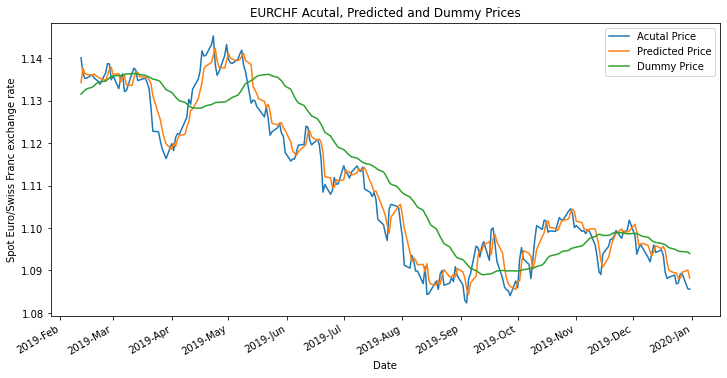

In [13]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

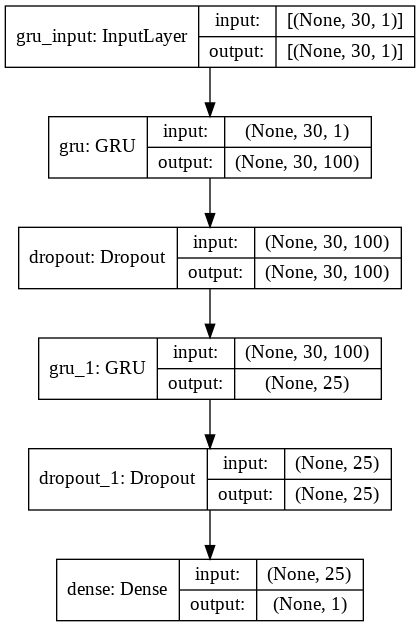

In [14]:
plot_model(model, show_shapes=True, expand_nested=True)

In [15]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.002410094270824614
RMSE:  0.049092710974487995
MAE:  0.03934062328595877


In [16]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_EURCHF/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_EURCHF/assets
